In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees = 90),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

normalize_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [11]:
test_path = './catdog_data/test'
train_path = './catdog_data/train'
validation_path = './catdog_data/validation'

train_data = ImageFolder(root = train_path, transform = train_transform)
test_data = ImageFolder(root = test_path, transform = normalize_transform)
validation_data = ImageFolder(root = validation_path, transform = normalize_transform)

In [12]:
batch_size = 100

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2
)

validation_dataloader = DataLoader(
    dataset = validation_data,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2
)

print('Number of training batches: ', len(train_dataloader))
print('Number of validation batches: ', len(validation_dataloader))
print('Number of testing batches: ', len(test_dataloader))

Number of training batches:  20
Number of validation batches:  6
Number of testing batches:  4


In [16]:
class CNN(nn.Module):

    def __init__(self, activation_function):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = 3, padding = 1)
        self.act1 = activation_function
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1)
        self.act2 = activation_function
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1)
        self.act3 = activation_function
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 2, kernel_size = 3, padding = 1)
        self.act4 = activation_function
        self.maxpool4 = nn.MaxPool2d(kernel_size = 2)

        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(2 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 2)
        self.act5 = activation_function
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.maxpool1(x)
        x = self.act2(self.conv2(x))
        x = self.maxpool2(x)
        x = self.act3(self.conv3(x))
        x = self.maxpool3(x)
        x = self.act4(self.conv4(x))
        x = self.maxpool4(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act5(self.fc1(x))
        x = self.fc2(x)
        return x

In [22]:
def train(network, data_loader, criterion, optimizer, device):
    network.train()
    running_loss = 0.0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
    
    return running_loss / len(data_loader.dataset)

def validation(network, data_loader, criterion, device):
    network.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            output = network(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    return val_loss / len(data_loader.dataset), 100 * correct / total

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 15
learning_rate = 0.001

activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LeakyReLU': nn.LeakyReLU()
}

results = {}

for name, activation_function in activation_functions.items():
    print(f"Training with {name} activation function...")

    model = CNN(activation_function).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []

    for epoch in range(num_epochs):
        train_loss = train(model, train_dataloader, criterion, optimizer, device)
        val_loss, val_accuracy = validation(model, validation_dataloader, criterion, device)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f} %")

    results[name] = {
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'val_accuracy_history': val_accuracy_history
    }

Training with ReLU activation function...
Epoch [1/15], Validation Loss: 0.6933, Validation Accuracy: 50.00 %
Epoch [2/15], Validation Loss: 0.6914, Validation Accuracy: 50.33 %
Epoch [3/15], Validation Loss: 0.6803, Validation Accuracy: 57.33 %
Epoch [4/15], Validation Loss: 0.6799, Validation Accuracy: 57.33 %
Epoch [5/15], Validation Loss: 0.6707, Validation Accuracy: 57.83 %
Epoch [6/15], Validation Loss: 0.6693, Validation Accuracy: 60.33 %
Epoch [7/15], Validation Loss: 0.6813, Validation Accuracy: 59.83 %
Epoch [8/15], Validation Loss: 0.6717, Validation Accuracy: 60.33 %
Epoch [9/15], Validation Loss: 0.6479, Validation Accuracy: 62.50 %
Epoch [10/15], Validation Loss: 0.6465, Validation Accuracy: 62.17 %
Epoch [11/15], Validation Loss: 0.6475, Validation Accuracy: 61.67 %
Epoch [12/15], Validation Loss: 0.6319, Validation Accuracy: 64.83 %
Epoch [13/15], Validation Loss: 0.6336, Validation Accuracy: 63.33 %
Epoch [14/15], Validation Loss: 0.6479, Validation Accuracy: 63.17 %
E

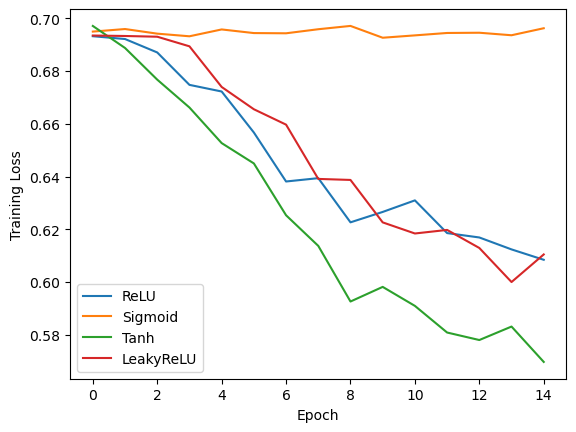

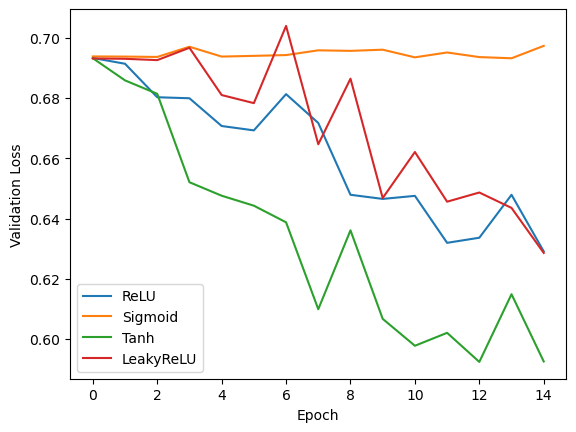

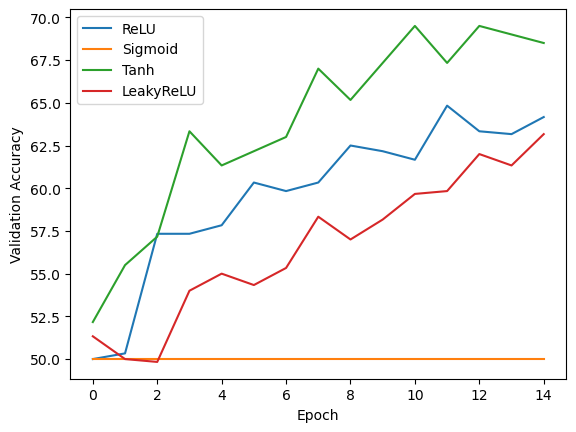

In [25]:
import matplotlib.pyplot as plt

plt.figure()
for name, data in results.items():
    plt.plot(data['train_loss_history'], label = name)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

plt.figure()
for name, data in results.items():
    plt.plot(data['val_loss_history'], label = name)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

plt.figure()
for name, data in results.items():
    plt.plot(data['val_accuracy_history'], label = name)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 15
learning_rate = 0.001

activation_functions = {
    'LogSigmoid': nn.LogSigmoid(),
    'ELU': nn.ELU(),
    'SiLU': nn.SiLU(),
    'Softplus': nn.Softplus()
}

results = {}

for name, activation_function in activation_functions.items():
    print(f"Training with {name} activation function...")

    model = CNN(activation_function).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []

    for epoch in range(num_epochs):
        train_loss = train(model, train_dataloader, criterion, optimizer, device)
        val_loss, val_accuracy = validation(model, validation_dataloader, criterion, device)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f} %")

    results[name] = {
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'val_accuracy_history': val_accuracy_history
    }

Training with LogSigmoid activation function...
Epoch [1/15], Validation Loss: 0.6995, Validation Accuracy: 50.00 %
Epoch [2/15], Validation Loss: 0.6933, Validation Accuracy: 50.00 %
Epoch [3/15], Validation Loss: 0.6933, Validation Accuracy: 50.00 %
Epoch [4/15], Validation Loss: 0.6947, Validation Accuracy: 50.00 %
Epoch [5/15], Validation Loss: 0.6936, Validation Accuracy: 50.00 %
Epoch [6/15], Validation Loss: 0.6937, Validation Accuracy: 50.00 %
Epoch [7/15], Validation Loss: 0.6948, Validation Accuracy: 50.00 %
Epoch [8/15], Validation Loss: 0.6982, Validation Accuracy: 50.00 %
Epoch [9/15], Validation Loss: 0.6941, Validation Accuracy: 50.00 %
Epoch [10/15], Validation Loss: 0.6932, Validation Accuracy: 50.00 %
Epoch [11/15], Validation Loss: 0.6940, Validation Accuracy: 50.00 %
Epoch [12/15], Validation Loss: 0.6943, Validation Accuracy: 50.00 %
Epoch [13/15], Validation Loss: 0.6935, Validation Accuracy: 50.00 %
Epoch [14/15], Validation Loss: 0.6933, Validation Accuracy: 50.

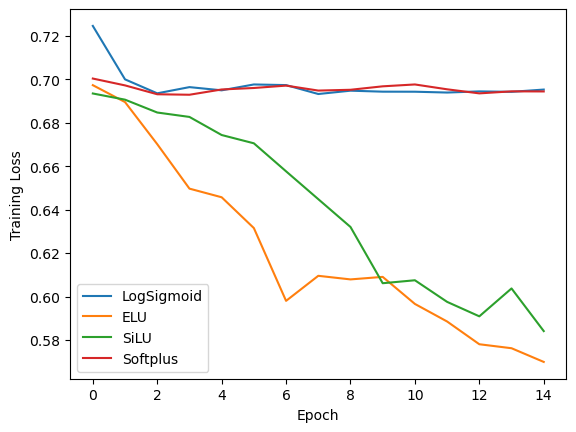

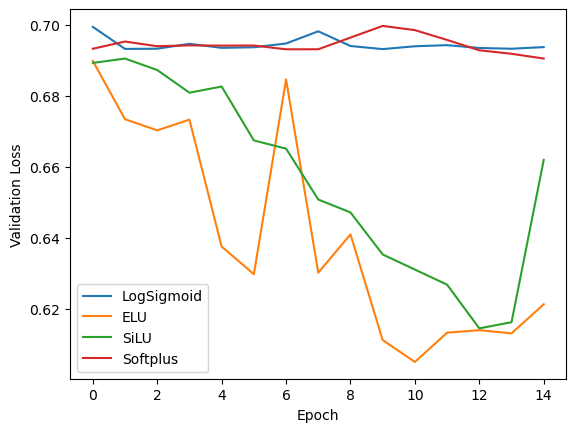

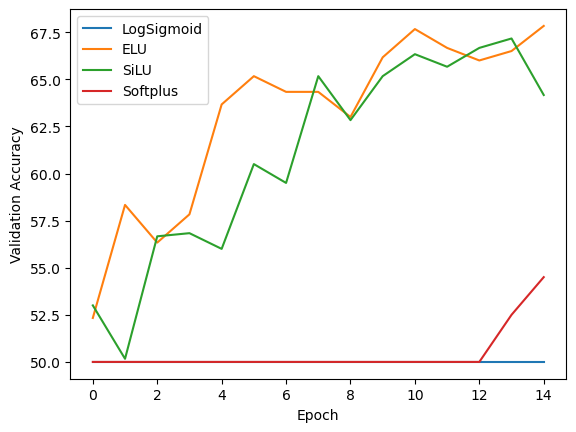

In [27]:
import matplotlib.pyplot as plt

plt.figure()
for name, data in results.items():
    plt.plot(data['train_loss_history'], label = name)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

plt.figure()
for name, data in results.items():
    plt.plot(data['val_loss_history'], label = name)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

plt.figure()
for name, data in results.items():
    plt.plot(data['val_accuracy_history'], label = name)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 15
learning_rate = 0.001

activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LeakyReLU': nn.LeakyReLU(),
    'LogSigmoid': nn.LogSigmoid(),
    'ELU': nn.ELU(),
    'SiLU': nn.SiLU(),
    'Softplus': nn.Softplus()
}

results = {}

for name, activation_function in activation_functions.items():
    print(f"Training with {name} activation function...")

    model = CNN(activation_function).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []

    for epoch in range(num_epochs):
        train_loss = train(model, train_dataloader, criterion, optimizer, device)
        val_loss, val_accuracy = validation(model, validation_dataloader, criterion, device)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f} %")

    results[name] = {
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'val_accuracy_history': val_accuracy_history
    }

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
for name, data in results.items():
    plt.plot(data['train_loss_history'], label = name)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

plt.figure()
for name, data in results.items():
    plt.plot(data['val_loss_history'], label = name)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

plt.figure()
for name, data in results.items():
    plt.plot(data['val_accuracy_history'], label = name)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    print("Memory allocated:", round(torch.cuda.memory_allocated(0)/1024**3, 2), "GB")
    print("Memory cached:", round(torch.cuda.memory_reserved(0)/1024**3, 2), "GB")
    print("Total memory:", round(torch.cuda.get_device_properties(0).total_memory / 1024**3, 2), "GB")

num_gpus = torch.cuda.device_count()
print(f"Number of GPUs: {num_gpus}")

for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

In [ ]:
import pickle

class CNN(nn.Module):

    def __init__(self, activation_function):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = 3, padding = 1)
        self.act1 = activation_function
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1)
        self.act2 = activation_function
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1)
        self.act3 = activation_function
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 2, kernel_size = 3, padding = 1)
        self.act4 = activation_function
        self.maxpool4 = nn.MaxPool2d(kernel_size = 2)

        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(2 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 2)
        self.act5 = activation_function
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.maxpool1(x)
        x = self.act2(self.conv2(x))
        x = self.maxpool2(x)
        x = self.act3(self.conv3(x))
        x = self.maxpool3(x)
        x = self.act4(self.conv4(x))
        x = self.maxpool4(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act5(self.fc1(x))
        x = self.fc2(x)
        return x

def train(network, data_loader, criterion, optimizer, device):
    network.train()
    running_loss = 0.0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
    
    return running_loss / len(data_loader.dataset)

def validation(network, data_loader, criterion, device):
    network.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            output = network(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    return val_loss / len(data_loader.dataset), 100 * correct / total

results = []

batch_sizes = [64, 128, 256]
learning_rates = [0.1, 0.01, 0.001]

activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LeakyReLU': nn.LeakyReLU(),
    'LogSigmoid': nn.LogSigmoid(),
    'ELU': nn.ELU(),
    'SiLU': nn.SiLU(),
    'Softplus': nn.Softplus()
}

optimizers = {
    'Stochastic Gradient Descent': optim.SGD,
    'Adam': optim.Adam
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 15

for batch_size in batch_sizes:
    print(f"\n== Batch size: {batch_size} ===")

    train_dataloader = DataLoader(
        dataset = train_data,
        batch_size = batch_size,
        shuffle = True,
        num_workers = 2
    )

    validation_dataloader = DataLoader(
        dataset = validation_data,
        batch_size = batch_size,
        shuffle = False,
        num_workers = 2
    )

    test_dataloader = DataLoader(
        dataset = test_data,
        batch_size = batch_size,
        shuffle = False,
        num_workers = 2
    )

    for learning_rate in learning_rates:
        print(f"\n --- Learning rate: {learning_rate} ---")

        for act_name, activation_function in activation_functions.items():
            for opt_name in optimizers:
                print(f"\nTraining {act_name} & {optimizer}...")

                model = CNN(activation_function).to(device)
                criterion = nn.CrossEntropyLoss()
                optimizer = opt_name(model.parameters(), lr = learning_rate)

                train_loss_history = []
                val_loss_history = []
                val_accuracy_history = []

                for epoch in range(num_epochs):
                    train_loss = train(model, train_dataloader, criterion, optimizer, device)
                    val_loss, val_accuracy = validation(model, validation_dataloader, criterion, device)

                    train_loss_history.append(train_loss)
                    val_loss_history.append(val_loss)
                    val_accuracy_history.append(val_accuracy)

                    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f} %")

                results.append({
                    "batch_size": batch_size,
                    "learning_rate": learning_rate,
                    "activation_function": act_name,
                    "optimizer": opt_name,
                    "train_loss_history": train_loss_history,
                    "val_loss_history": val_loss_history,
                    "val_accuracy_history": val_accuracy_history
                })

with open("cnn_experiments.pkl", "wb") as f:
    pickle.dump(results, f)

print("\nAll results saved to cnn_experiments.pkl")

In [ ]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd

with open("cnn_experiments.pkl", "rb") as f:
    results = pickle.load(f)

df = pd.DataFrame(results)

subset_relu = df[(df["activation_function"] == "ReLU")]
subset_sigmoid = df[(df["activation_function"] == "Sigmoid")]
subset_tanh = df[(df["activation_function"] == "Tanh")]
subset_leakyrelu = df[(df["activation_function"] == "LeakyReLU")]
subset_logsigmoid = df[(df["activation_function"] == "LogSigmoid")]
subset_elu = df[(df["activation_function"] == "ELU")]
subset_silu = df[(df["activation_function"] == "SiLU")]
subset_softplus = df[(df["activation_function"] == "Softplus")]

plt.figure()
for _, row in subset_relu.iterrows():
    label = f"BS = {row['batch_size']}, LR = {row[learning_rate]}, OPT = {row['optimizer']}"
    plt.plot(data['val_accuracy_history'], label = label)
plt.title("Validation Accuracy - ReLU")
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for _, row in subset_sigmoid.iterrows():
    label = f"BS = {row['batch_size']}, LR = {row[learning_rate]}, OPT = {row['optimizer']}"
    plt.plot(data['val_accuracy_history'], label = label)
plt.title("Validation Accuracy - Sigmoid")
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for _, row in subset_tanh.iterrows():
    label = f"BS = {row['batch_size']}, LR = {row[learning_rate]}, OPT = {row['optimizer']}"
    plt.plot(data['val_accuracy_history'], label = label)
plt.title("Validation Accuracy - Tanh")
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for _, row in subset_leakyrelu.iterrows():
    label = f"BS = {row['batch_size']}, LR = {row[learning_rate]}, OPT = {row['optimizer']}"
    plt.plot(data['val_accuracy_history'], label = label)
plt.title("Validation Accuracy - Leaky ReLU")
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for _, row in subset_logsigmoid.iterrows():
    label = f"BS = {row['batch_size']}, LR = {row[learning_rate]}, OPT = {row['optimizer']}"
    plt.plot(data['val_accuracy_history'], label = label)
plt.title("Validation Accuracy - LogSigmoid")
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for _, row in subset_elu.iterrows():
    label = f"BS = {row['batch_size']}, LR = {row[learning_rate]}, OPT = {row['optimizer']}"
    plt.plot(data['val_accuracy_history'], label = label)
plt.title("Validation Accuracy - ELU")
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for _, row in subset_silu.iterrows():
    label = f"BS = {row['batch_size']}, LR = {row[learning_rate]}, OPT = {row['optimizer']}"
    plt.plot(data['val_accuracy_history'], label = label)
plt.title("Validation Accuracy - SiLU")
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for _, row in subset_softplus.iterrows():
    label = f"BS = {row['batch_size']}, LR = {row[learning_rate]}, OPT = {row['optimizer']}"
    plt.plot(data['val_accuracy_history'], label = label)
plt.title("Validation Accuracy - Softplus")
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()